# DIC4/587: Phase 2
*Contributors: Seungmin Lee, David Huang*

---
## Deliverables

1. Algorithms/Visualizations: Apply 5 different significant and relevant
algorithms (ML, MR, and/or statistical models) to your data and create visualizations for
the results. 
    - For 487 students: at least 1 of the 5 algorithms must be one that was not
discussed in class. 
    - For 587 students: at least 2 must be from outside of class. 
    - These outside algorithms can come from the class textbooks, or other sources. Cite the appropriate sources for each outside algorithm you choose to apply.
2. Explanation and Analysis: For each of the 5 above algorithms, provide
justification for why you chose the particular algorithm, and discuss the effectiveness of
the algorithm when applied to your data to answer questions related to your problem
statement. 
    - This should include discussion of any relevant metrics for demonstrating
model effectiveness, as well as any intelligence you were able to gain from application of
the algorithm to your data.


## Ideas
- Incorperating word count into Naive Bayes Classification for description of what the permits were used for (ex. swimming pool reno)
- Log Regression

*Note: Disregarding driveway/sidewalks*

In [190]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [191]:
data = pd.read_csv('../Dataset/ICP_Residential_Austin2017up.csv')
data.shape

(55976, 61)

Word Count
---

In [153]:
'''
Word Count Function
Input: text -> String
Output: Counter[String -> Int]
Returns a dictionary containing word counts
'''
def wc(text):
    words = re.findall("[a-z']+", text.lower().replace("<br />", ""))
    return Counter(words)

In [172]:
data['word_counts'] = data['Description'].astype(str).replace('\d+','').map(wc)
data['Total New Add SQFT'] = data['Total New Add SQFT'].fillna(0)

In [155]:
data['word_counts']

0        {'this': 1, 'is': 1, 'the': 1, 'accessory': 1,...
1        {'inground': 1, 'swimming': 1, 'pool': 1, 'and...
2        {'new': 1, 'story': 1, 'singlefamily': 1, 'res...
3        {'addition': 1, 'of': 1, 'a': 1, 'new': 1, 'de...
4        {'addition': 1, 'to': 1, 'add': 2, 'sf': 1, 'c...
                               ...                        
55968    {'partial': 1, 'demo': 1, 'interior': 1, 'remo...
55970    {'interior': 1, 'remodel': 2, 'master': 1, 'ba...
55972    {'new': 1, 'inground': 1, 'swimming': 1, 'pool...
55973    {'cr': 1, 'new': 1, 'story': 1, 'bedroom': 1, ...
55975    {'sqft': 2, 'pool': 1, 'w': 1, 'stepping': 1, ...
Name: word_counts, Length: 33457, dtype: object

K-Means
---
Before starting with the k-Means clustering, we will first use an elbow curve to determine the optimal value for k.

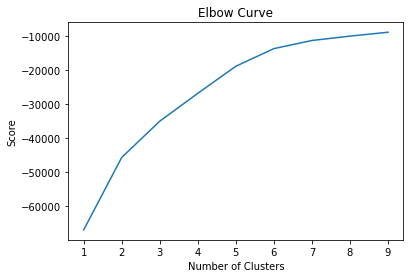

In [156]:
scaler = StandardScaler()
scaled_kmeans = pd.DataFrame(scaler.fit_transform(data[["Total New Add SQFT", "Total Job Valuation"]]),columns=["Total New Add SQFT","Total Job Valuation"])

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(scaled_kmeans).score(scaled_kmeans) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The slope of the curve is the greatest for the first 2 values of k but significantly reduces as k increases. We will be using $k=6$ as afterwards there are minimal increases in accuracy.

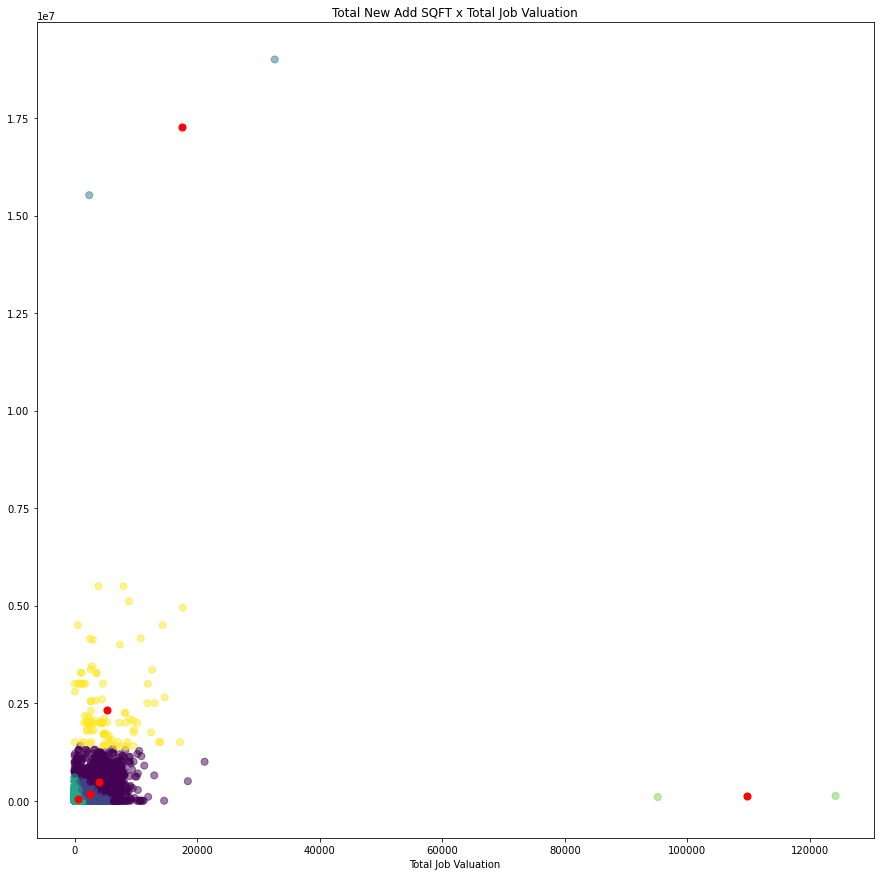

In [157]:
kmeans = KMeans(n_clusters = 6).fit(scaled_kmeans)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.figure(figsize=(15,15))
plt.xlabel('Total New Add SQFT')
plt.xlabel('Total Job Valuation')
plt.title('Total New Add SQFT x Total Job Valuation')
plt.scatter(data["Total New Add SQFT"], data["Total Job Valuation"], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=50)

As shown above, there are several outliers leaving inconsistencies. The cluster centroids for the yellow patch, along with the two on the top left and bottom right have too much of a gap between the clusters. To more accurately depict the results of k-Means, we will only work with data within 3 standard deviations.

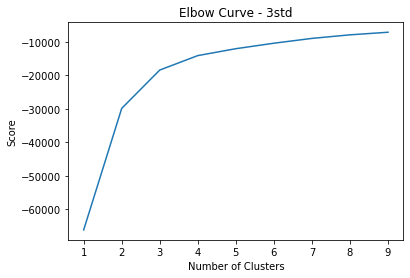

In [158]:
data_3std = data[(np.abs(stats.zscore(data[["Total New Add SQFT", "Total Job Valuation"]])) < 3).all(axis=1)]
scaled_kmeans = pd.DataFrame(scaler.fit_transform(data_3std[["Total New Add SQFT", "Total Job Valuation"]]),columns=["Total New Add SQFT","Total Job Valuation"])
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(scaled_kmeans).score(scaled_kmeans) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve - 3std')
plt.show()

We will assign out k value to be 4 as this is the last instance of any noticable growth in the slope.

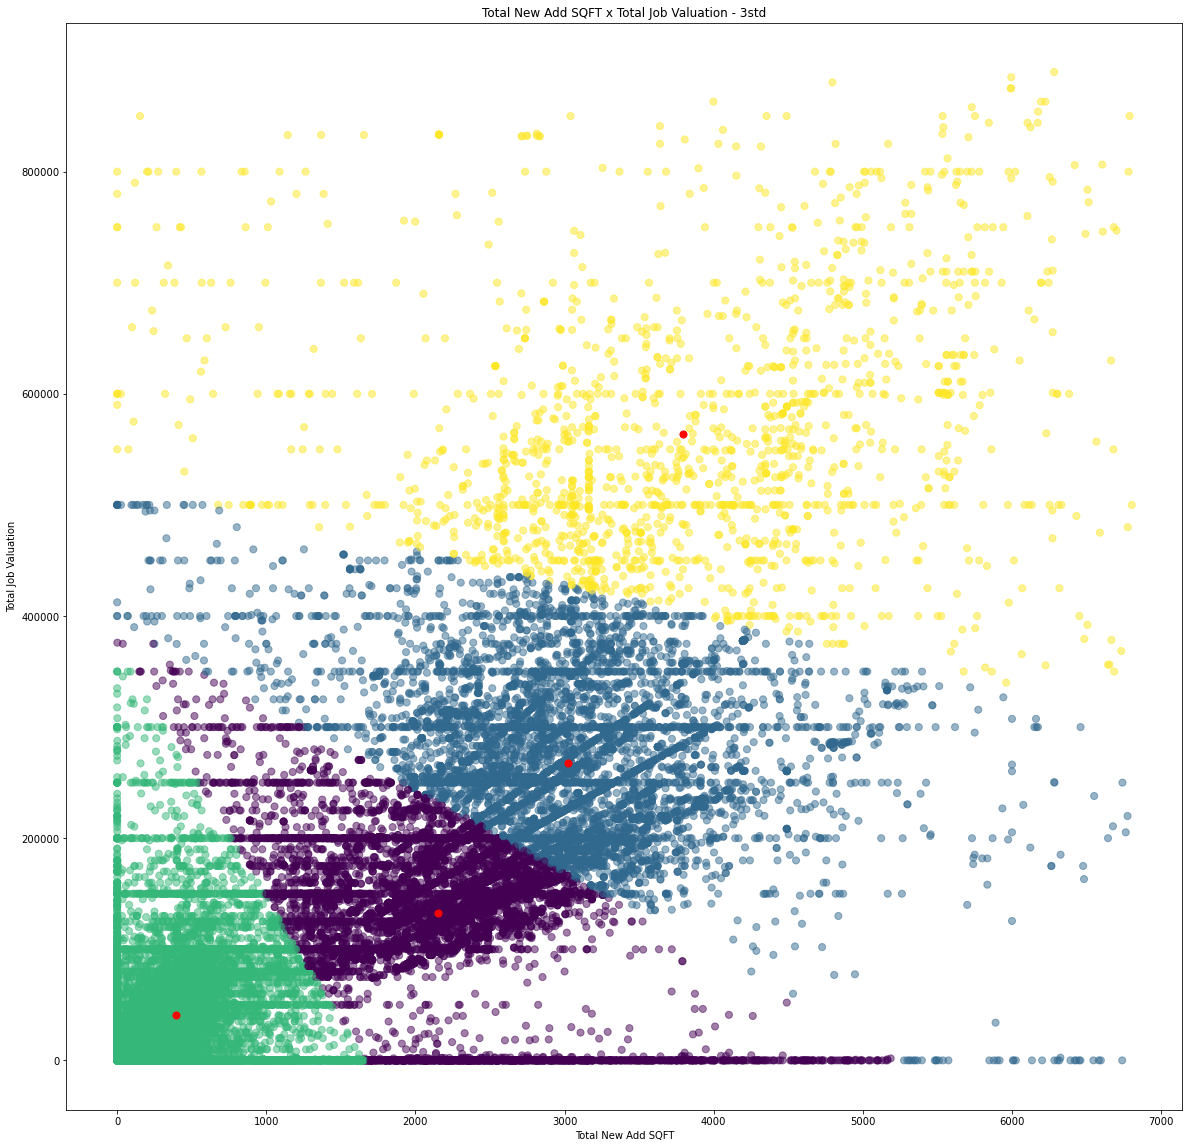

In [159]:
kmeans = KMeans(n_clusters = 4).fit(scaled_kmeans)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.figure(figsize=(20,20))
plt.xlabel('Total New Add SQFT')
plt.ylabel('Total Job Valuation')
plt.title('Total New Add SQFT x Total Job Valuation - 3std')
plt.scatter(data_3std["Total New Add SQFT"], data_3std["Total Job Valuation"], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=50)

With this, we can determine a more appropriate class using the boundary conditions shown by the clustering groups.

K-NN
---
Similar to the approach with k-Means, we will first see the accuracy of the classification model.

In [160]:
x = data_3std["Total New Add SQFT"].values.reshape(-1, 1)
y = data_3std["Total Job Valuation"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

classifier = KNeighborsClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
classifier.score(x_test, y_test)

0.21479511664450623

The accuracy of this current model is inefficient. However, we wish to find the correlation between SQFT and Total Job Valuation from our finding from the heatmap produced from Phase 1. What if we change our k value?

Text(0.5, 0, 'Number of Neighbors')

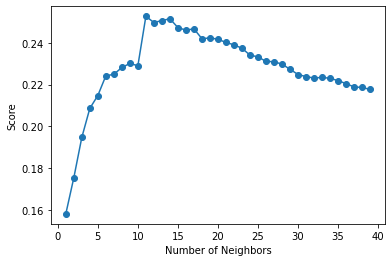

In [161]:
acc=[]
for i in range(1,40):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(x_train, y_train)
    acc.append(classifier.score(x_test, y_test))
plt.plot(range(1,40), acc, marker='o')
plt.ylabel('Score')
plt.xlabel('Number of Neighbors')

There is a substantial increase in accuracy between the k values [2,3] and [12,13]. Regardless, k-NN would not be the best model for our purpose as the highest score achieved is 0.25, which is still not enough.

In [162]:
print(kmeans.labels_[50:123])

[0 0 0 2 1 1 0 2 2 2 1 3 1 2 0 1 2 0 3 2 1 2 2 2 2 0 2 2 2 2 0 0 1 1 2 2 2
 0 2 2 1 2 0 2 0 2 1 1 1 2 0 3 0 0 3 1 0 0 2 1 1 2 2 2 1 2 2 2 2 2 0 2 2]


In [189]:
data_3std = data[(np.abs(stats.zscore(data[["Total New Add SQFT", "Total Job Valuation"]])) < 3)]
data_3std['Permit Class'] = data['Permit Class']
data_3std = data_3std.dropna(subset=["Total New Add SQFT", "Total Job Valuation"])


from sklearn import linear_model
import statsmodels.api as sm

x = data_3std[["Total New Add SQFT"]]
y = data_3std["Total Job Valuation"]
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 14554.197826528136
Coefficients: 
 [73.621317]
                             OLS Regression Results                            
Dep. Variable:     Total Job Valuation   R-squared:                       0.602
Model:                             OLS   Adj. R-squared:                  0.602
Method:                  Least Squares   F-statistic:                 8.365e+04
Date:                 Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                         22:00:56   Log-Likelihood:            -7.0145e+05
No. Observations:                55298   AIC:                         1.403e+06
Df Residuals:                    55296   BIC:                         1.403e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

c:\Users\josep\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [164]:
data['Permit Class'].unique()

array(['R- 330  Accessory Use to Primary',
       'R- 329 Res Structures Other Than Bldg',
       'R- 101 Single Family Houses', 'R- 434 Addition & Alterations',
       'R- 437 Residential Boat Dock', 'R- 103 Two Family Bldgs',
       'R- 438 Residential Garage/Carport Addn',
       'R- 102 Secondary Apartment', 'Residential',
       'R- 435 Renovations/Remodel',
       'R- 328 Resident Other Nonresident Bldg',
       'R- 436 Addn to increase housing units'], dtype=object)